In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import pandas as pd
import numpy as np
import random
import copy
from tqdm import tqdm
from collections import deque

/home/ec2-user/.local/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.is_available()

False

In [105]:
#environment class
class Environment():
    
    #initialize dataset, a random trajectory, and current cycle
    def __init__(self):
        self.dataset = pd.read_csv('train.csv')
        self.episode = self.get_trajectory(np.random.randint(low=1, high=79, size=1))
        self.cycle = 0
        
    #get random trajectory
    def get_trajectory(self, engine_id):
        return self.dataset[self.dataset.engine_id==engine_id.item()].health_indicator.to_numpy()
    
    #reset environment    
    def reset(self):
        self.cycle = 0
        self.episode = self.get_trajectory(np.random.randint(low=0, high=79, size=1))
        
    #return current state
    def get_state(self):
        return np.array([self.cycle, self.episode[self.cycle]])
    
    #take action
    def take_action(self, action):
        if action == 0:
            #failure occurs
            if self.cycle+1 == self.episode.size:
                res = (None, -78, True)
            #continued operation, return 1 and continue episode
            else:
                res = (np.array([self.cycle, self.episode[self.cycle+1]]), self.episode[self.cycle], False)
            #move to next state
            self.cycle+=1
        elif action == 1:
            res = (None, -self.episode[self.cycle], True)
        return res

In [106]:
class Transition():
    
    def __init__(self, state, action, state_new, reward, term ):
        self.state = state
        self.action = action
        self.state_new = state_new
        self.reward = reward
        self.term = term
        
class ReplayMemory():

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [115]:
#dqn model clas 
class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        self.lin1 = nn.Linear(2,30)
        self.lin2 = nn.Linear(30,2)

    def forward(self, x):
        x = self.lin1(x)
        x = F.relu(x)
        x = self.lin2(x)
        return x

In [116]:
def get_action(net, state, epsilon):
    with torch.no_grad():
        greedy = np.random.choice([True, False], p=[1-epsilon, epsilon])
        if greedy:
            state = torch.tensor(state, dtype=torch.float32)
            q_values = net(state)
            action = torch.argmax(q_values, dim=0)
        else:
            action = random.choice([0,1])
        return action

In [117]:
class Agent():
    
    def __init__(self):
        
        #hyperparameters
        self.exp_replay_size = 100000
        self.gamma = 0.99
        self.epsilon = 0.01
        self.target_update_steps = 1000
        self.num_episodes = 5000
        self.batch_size = 64
        self.train_step_count = 4
        self.steps = 0
        self.lr = 0.001
        self.eps_decay = 1e-6
        self.loss_func = nn.MSELoss()
        self.optimizer_steps = 0
        self.optimizer_events = []
        
        #networks
        self.QNet = DQN()
        self.TNet = DQN()
        self.optimizer = torch.optim.Adam(self.QNet.parameters(), lr=self.lr)
        
        #replay buffer
        self.ER = ReplayMemory(self.exp_replay_size)

In [118]:
def optimize(agent):
    
    agent.optimizer_steps+=1
    sample_transitions = agent.ER.sample(agent.batch_size)
            
    #get batch information
    state_batch = [transition.state for transition in sample_transitions]
    action_batch = [transition.action for transition in sample_transitions]
    reward_batch = [transition.reward for transition in sample_transitions]
    state_new = [transition.state_new for transition in sample_transitions]
    term_batch = [transition.term for transition in sample_transitions]

    state_tensor = torch.tensor(state_batch, dtype=torch.float32, requires_grad=True)
    state_tensor = state_tensor.reshape(agent.batch_size, -1)
    
    policy_preds = agent.QNet(state_tensor)
    policy_values = torch.stack([qvalues[idx] for qvalues, idx in zip(policy_preds, map(int, action_batch))])
    
    state_new_tensor = torch.tensor(state_batch, dtype=torch.float32, requires_grad=True)
    state_new_tensor = torch.nan_to_num(state_new_tensor, nan=0.0)
    state_new_tensor = state_new_tensor.reshape(agent.batch_size, -1)
    target_values = agent.TNet(state_new_tensor)
    target_values = torch.max(target_values, dim=1).values
    
    for idx, is_term in enumerate(term_batch):
        target_values[idx] = 0.0 if is_term else target_values[idx]
        
    target_values = agent.gamma * target_values + torch.tensor(reward_batch, dtype=torch.float32, requires_grad=True)
    
    return agent.loss_func(policy_values, target_values)

In [119]:
agent = Agent()
agent.QNet.train()
losses = []
cummulative_rewards = []

for episode in tqdm(range(agent.num_episodes)):
    
    environment = Environment()
    cummulative_reward = 0

    while True:
        
        #observation
        state = environment.get_state()
        action = get_action(agent.QNet, state, agent.epsilon)
        state_new, reward, terminated = environment.take_action(action)
        #append to replay buffer
        agent.ER.push(state, action, state_new, reward, terminated)

        #update variables
        cummulative_reward+=reward
                
        #increament step count
        agent.steps+=1
        
        #train after every 'train_step_count' steps
        if agent.steps%agent.train_step_count==0 and agent.ER.__len__()>agent.batch_size:
            agent.optimizer.zero_grad()
            loss = optimize(agent)
            loss.backward()
            agent.optimizer.step()
            agent.epsilon=max(0, agent.epsilon-agent.eps_decay)
            losses.append(loss.item())
            
        #copy weights to target network after every 'target_update_steps' updates
        if agent.steps%agent.target_update_steps==0:
            agent.optimizer_events.append(agent.optimizer_steps)
            agent.TNet.load_state_dict(agent.QNet.state_dict())
        
        #break when episode is complete
        if terminated:
            break
            
    cummulative_rewards.append(cummulative_reward)
    
    if agent.epsilon==0:
        print("Epsilon is zero...")
        break

 12%|████████████████████▏                                                                                                                                                       | 588/5000 [01:16<09:35,  7.67it/s]

Epsilon is zero...


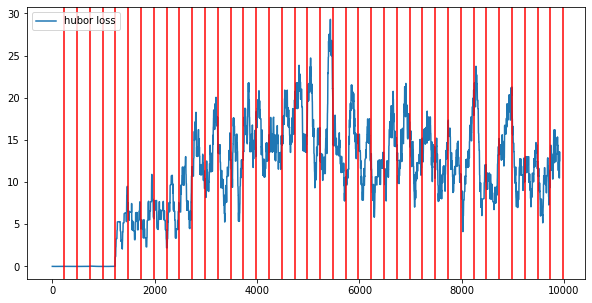

In [120]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot((np.convolve(losses, np.ones(100), 'valid') / 100), label='hubor loss')
for event in agent.optimizer_events:
    plt.axvline(event, c='red')
plt.legend()
plt.show()

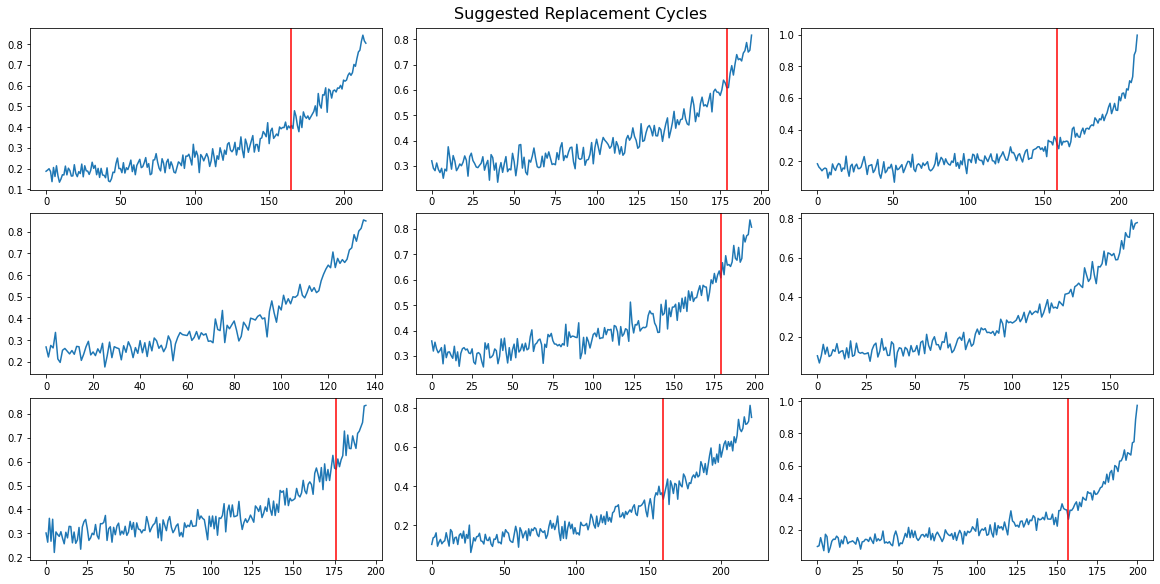

In [124]:
df = pd.read_csv('train.csv')
agent.QNet.eval()
fig, axs = plt.subplots(3, 3, constrained_layout=True)
fig.suptitle('Suggested Replacement Cycles', fontsize=16)
fig.set_figheight(8)
fig.set_figwidth(16)
for row in range(3):
    for col in range(3):
        replacement_events = []
        engine_id = np.random.randint(low=1, high=79, size=1)
        trajectory = df[df.engine_id==engine_id.item()].health_indicator.to_numpy()
        for idx, health in enumerate(trajectory):
            action = torch.argmax(agent.QNet(torch.tensor([idx, health], dtype=torch.float32)))
            if action == 1:
                replacement_events.append(idx)
        axs[row,col].plot(trajectory)
        if replacement_events:
            suggested_replacement = replacement_events[0]
            axs[row,col].axvline(suggested_replacement, c='red')
        else:
            pass
fig.show()

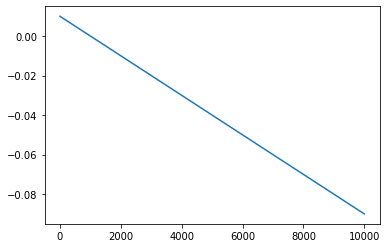

In [122]:
plt.plot([0.01-(1e-5*i) for i in range(10000)])